In [108]:
from functions import *

import functions
from importlib import reload
reload(functions)

<module 'functions' from 'C:\\Users\\adam-\\Documents\\Thesis\\ThesisClustering\\functions.py'>

Short display of the data.

In [109]:
FULL_DF = pd.read_csv("philosophy_data.csv", converters={"tokenized_sentence": pd.eval})

In [110]:
#Filter dataframe to training, test, fulldataset
train_data = 0.8
indexes = [i for i in list(FULL_DF.sample(frac=train_data).index)]
DF_TRAIN = FULL_DF.iloc[indexes]
DF_TRAIN.reset_index(drop = True, inplace = True)
DF_TEST = FULL_DF.iloc[~FULL_DF.index.isin(indexes)]
DF_TEST.reset_index(drop = True, inplace = True)

#Comment these to be able to train.
DF_TEST = FULL_DF
DF_TRAIN = FULL_DF

len(FULL_DF.index), len(DF_TEST.index), len(DF_TRAIN.index)

(308822, 308822, 308822)

In [111]:
DF_TRAIN.sample(5)

,school,author,title,tokenized_sentence,num_of_chars,num_of_words,string_sentence
15306,rationalism,Nicolas Malebranche,malebranche: the search after truth,"[general, causes, errors, passions, exactly, c...",60,8,general causes errors passions exactly causing...
88604,phenomenology,Maurice Merleau-Ponty,phenomenology of perception,"[screen, removed, see, remoteness, born, inter...",54,7,screen removed see remoteness born intervening...
232265,aristotle,Aristotle,the complete works of aristotle vol 2,"[warmer, outer, parts, inner, parts, chilled, ...",91,14,warmer outer parts inner parts chilled owing g...
43465,analytic,David Kellogg Lewis,philosophical papers volume 2,"[cure, use, fancier, conditional, probabilitie...",99,10,cure use fancier conditional probabilities con...
13989,rationalism,Nicolas Malebranche,malebranche: the search after truth,"[reputation, rich, learned, virtuous, produces...",102,11,reputation rich learned virtuous produces imag...


Extract the tokenized_sentence DF["tokenized_sentence"] sentences and append them into a python list.

Load w2v model, Skip-gram, CBOW

In [112]:
skipgram_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,       # Dimensionality of word embeddings
            sg = 1,                # SKIPGRAM
            window=5,              # Word window for context evaluation
            epochs=10)             # Number of epochs training over corpus

cbow_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,
            sg = 0,                # CBOW
            window=5,
            epochs=10)

len(skipgram_w2v.wv), len(cbow_w2v.wv)

(26653, 26653)

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.
Can also be used with pretrained models.

In [113]:
DF_TEST, skipgram_sentences = vectorize_sentences(skipgram_w2v.wv, DF_TEST)
DF_TEST, cbow_sentences = vectorize_sentences(cbow_w2v.wv, DF_TEST)

#Should be equal
len(DF_TEST["tokenized_sentence"]), len(skipgram_sentences), len(cbow_sentences)

(307742, 307742, 307742)

Fetch the number of unique School of Thoughts.

In [114]:
unique_schools = DF_TEST["school"].unique().tolist()
print(unique_schools)
num_clusters = len(unique_schools)

['rationalism', 'analytic', 'empiricism', 'phenomenology', 'capitalism', 'continental', 'plato', 'aristotle', 'german_idealism', 'marxism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

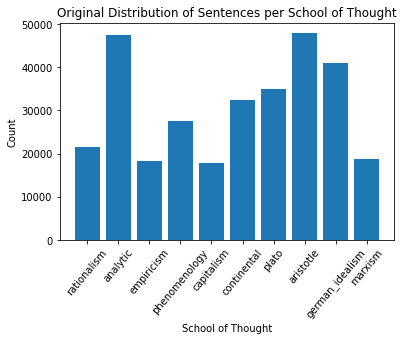

In [115]:
total_dict = dict.fromkeys(unique_schools, 0)
for school in DF_TEST["school"]:
    total_dict[school] += 1

plt.bar(range(len(total_dict)), total_dict.values(), align='center')
plt.xticks(range(len(total_dict)), total_dict.keys())
plt.xticks(rotation=50)
plt.xlabel("School of Thought")
plt.ylabel("Count")
plt.title("Original Distribution of Sentences per School of Thought")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [116]:
start = time.time()

#Skip-gram and cbow.
skipgram_w2v_kmeans, skipgram_w2v_labels, skipgram_w2v_centroids = apply_kmeans(num_clusters, skipgram_sentences)
cbow_w2v_kmeans, cbow_w2v_labels, cbow_w2v_centroids = apply_kmeans(num_clusters, cbow_sentences)

end = time.time()
print(end - start)

603.5184109210968


Apply scatter plot on kmeans results using TSNE.
Scatter plot using TSNE, PCA and UMAP

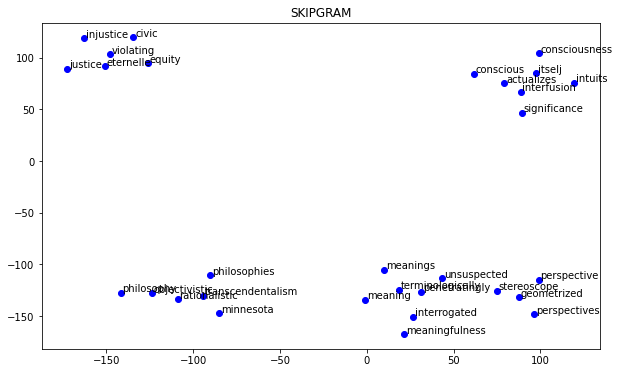

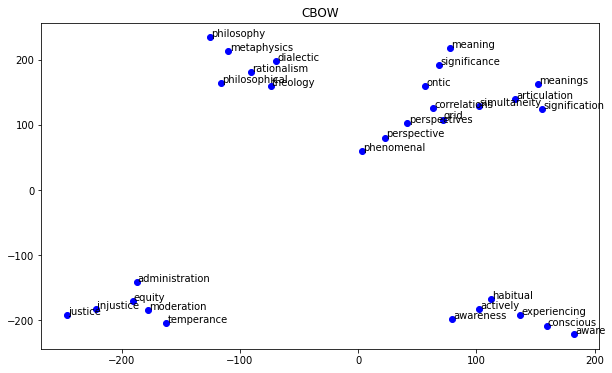

In [117]:
# scatter_plot(type='pca', labels=skipgram_w2v_labels, values=skipgram_sentences)
# scatter_plot(type='pca', labels=cbow_w2v_labels, values=cbow_sentences)

words = ['meaning', 'philosophy', 'justice', 'conscious', 'perspective']
plot_similar_words(skipgram_w2v.wv, words, title="SKIPGRAM",top_words=5)
plot_similar_words(cbow_w2v.wv, words,title="CBOW", top_words=5)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

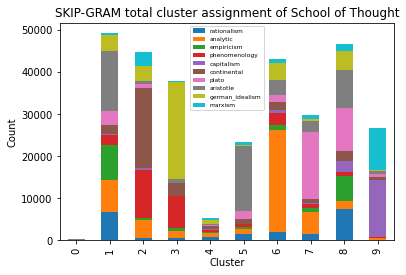

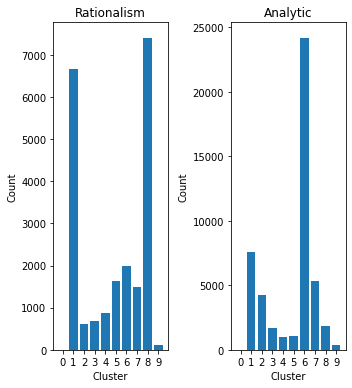

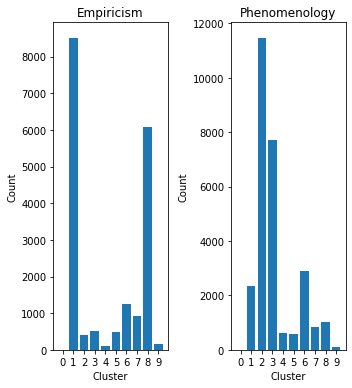

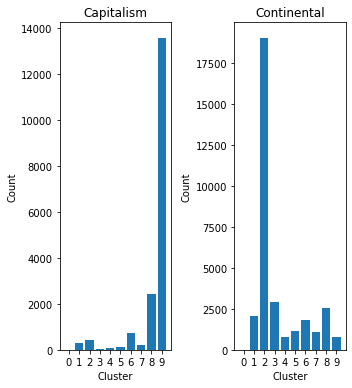

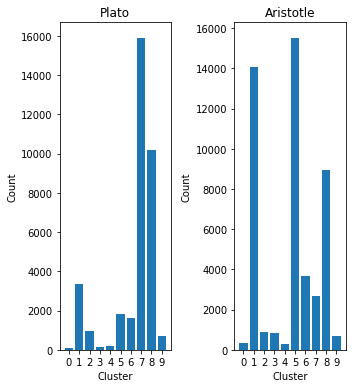

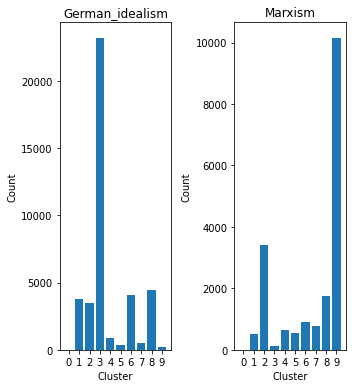

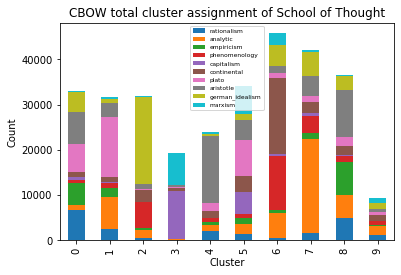

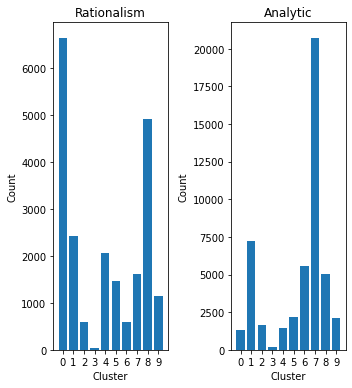

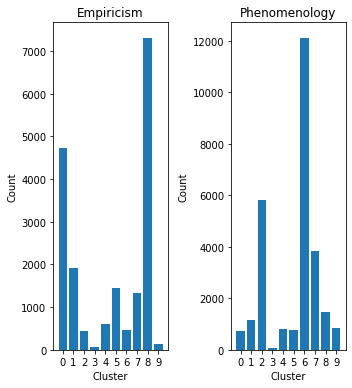

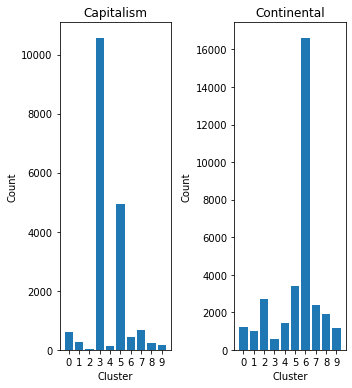

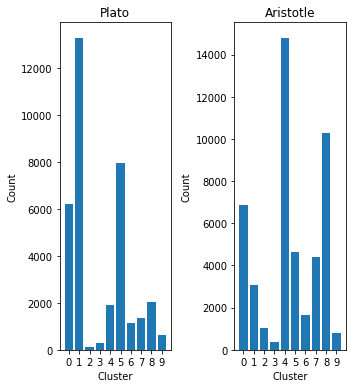

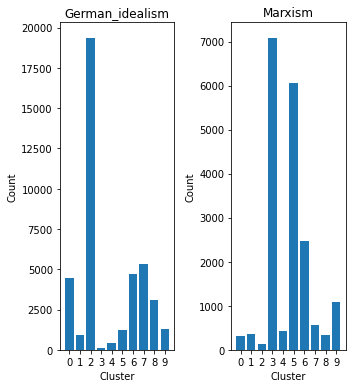

In [118]:
#How many times cluster n was assigned to specific SOT
cluster_n_assigned(DF=DF_TEST, labels=skipgram_w2v_labels, schools=unique_schools, name='skip-gram')
cluster_n_assigned(DF=DF_TEST, labels=cbow_w2v_labels, schools=unique_schools, name='cbow')

Make a list and convert all "plato" to 0 and "aristotle" to 1, etc.
This can then be applied with the predicted labels with v_measure.

In [119]:
original_labels = [unique_schools.index(school) for school in DF_TEST["school"]]

Apply v-measure.

In [120]:
#w2v
skipgram_v_measure = v_measure_score(original_labels, skipgram_w2v_labels)
cbow_v_measure = v_measure_score(original_labels, cbow_w2v_labels)

skipgram_v_measure, cbow_v_measure

(0.27974836545711823, 0.2349244499353406)

In [121]:
words = ['thinking', 'teaching', 'justice', 'conscious', 'perspective']

In [122]:
most_similar_skip_gram = {word: [word_tuple for word_tuple in skipgram_w2v.wv.most_similar([word], topn=5)] for word in words}
pd.DataFrame.from_dict(most_similar_skip_gram, orient='index',
                       columns=[i for i in range(1,6)])

,1,2,3,4,5
thinking,"(intuiting, 0.4973452091217041)","(thought, 0.49687713384628296)","(griffin, 0.4903586506843567)","(wishful, 0.4681447744369507)","(intuits, 0.46510788798332214)"
teaching,"(theorize, 0.5096712112426758)","(cleverest, 0.5025647282600403)","(mistook, 0.4979490041732788)","(practising, 0.4898912012577057)","(laymen, 0.47829389572143555)"
justice,"(injustice, 0.5678490996360779)","(equity, 0.5020952224731445)","(violating, 0.497832715511322)","(civic, 0.4948635399341583)","(eternelle, 0.4894494414329529)"
conscious,"(itselj, 0.5411063432693481)","(consciousness, 0.5356148481369019)","(actualizes, 0.5324965715408325)","(intuits, 0.529409646987915)","(interfusion, 0.5214060544967651)"
perspective,"(geometrized, 0.528681755065918)","(stereoscope, 0.5241879820823669)","(unsuspected, 0.493755042552948)","(penetratingly, 0.488069087266922)","(perspectives, 0.4806685149669647)"


In [123]:
most_similar_cbow = {word: [word_tuple for word_tuple in cbow_w2v.wv.most_similar([word], topn=5)] for word in words}
pd.DataFrame.from_dict(most_similar_cbow, orient='index',
                       columns=[i for i in range(1,6)])


,1,2,3,4,5
thinking,"(intuiting, 0.5768263936042786)","(thought, 0.5641741156578064)","(perceiving, 0.5069957971572876)","(wishful, 0.5021807551383972)","(ratiocinative, 0.4812124967575073)"
teaching,"(instruction, 0.7000312209129333)","(practise, 0.6885703206062317)","(students, 0.6874408721923828)","(learned, 0.6744164824485779)","(teach, 0.6735115647315979)"
justice,"(equity, 0.692881166934967)","(injustice, 0.672749936580658)","(temperance, 0.6092473268508911)","(moderation, 0.604701578617096)","(administration, 0.5688093900680542)"
conscious,"(actively, 0.6351365447044373)","(aware, 0.6205617189407349)","(habitual, 0.602514386177063)","(experiencing, 0.5942793488502502)","(awareness, 0.5804287791252136)"
perspective,"(perspectives, 0.6688938140869141)","(grid, 0.603778600692749)","(phenomenal, 0.5914834141731262)","(correlations, 0.5893836617469788)","(simultaneity, 0.5779886841773987)"


In [124]:
from sklearn.metrics import completeness_score, homogeneity_score
#1
print(f'Completeness = {completeness_score([0, 0, 1, 1], [0, 0, 0, 0])}')
print(f'Homogeneity = {homogeneity_score([0, 0, 1, 1], [0, 0, 0, 0])}')
#2
print(f'Completeness = {completeness_score([0, 0, 1, 1], [0, 0,  1, 1])}')
print(f'Homogeneity = {homogeneity_score([0, 0, 1, 1], [0, 0, 1, 1])}')
#3
print(f'Completeness = {completeness_score([0, 0, 1, 1], [0, 1, 2, 3])}')
print(f'Homogeneity = {homogeneity_score([0, 0, 1, 1], [0, 1, 2, 3])}')
#4
print(f'Completeness = {completeness_score([0, 0, 1, 1], [0, 1, 0, 1])}')
print(f'Homogeneity = {homogeneity_score([0, 0, 1, 1], [0, 1, 0, 1])}')

# print(v_measure_score([0, 0, 1, 1], [0, 0, 0, 0]))
# print(v_measure_score([0, 0, 1, 1], [0, 0, 0, 0]))
skip_gram_completeness = completeness_score(original_labels, skipgram_w2v_labels)
skip_gram_homogenity = homogeneity_score(original_labels, skipgram_w2v_labels)

skip_gram_completeness, skip_gram_homogenity

Completeness = 1.0
Homogeneity = 0.0
Completeness = 1.0
Homogeneity = 1.0
Completeness = 0.49999999999999994
Homogeneity = 0.9999999999999999
Completeness = 0.0
Homogeneity = 0.0


(0.28823685310129793, 0.2717455419109516)

Calculate the best v_measure.
Apply different values for window/vector_size/iterations.
vector_size: 50 -> 100 -> 300
window: 2 -> 3 -> 5 -> 7

Saving the V-max in the dataframes.

In [ ]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 50
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

In [ ]:
v_measure_dict_50 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 50 Vec Size
v_measure_plot_dict_50 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_50 = pd.DataFrame.from_dict(v_measure_plot_dict_50, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_50.style.set_caption("Overview of V-measure results")

In [ ]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 100
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

In [ ]:
v_measure_dict_100 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 100 Vec Size
v_measure_plot_dict_100 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_100 = pd.DataFrame.from_dict(v_measure_plot_dict_100, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_100.style.set_caption("Overview of V-measure results")

In [ ]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 300
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

In [ ]:
v_measure_dict_300 = {"skipgram_2": v_measure_list_skipgram_2,
                   "skipgram_3": v_measure_list_skipgram_3,
                   "skipgram_5": v_measure_list_skipgram_5,
                   "skipgram_7": v_measure_list_skipgram_7,
                   "cbow_2": v_measure_list_cbow_2,
                   "cbow_3": v_measure_list_cbow_3,
                   "cbow_5": v_measure_list_cbow_5,
                   "cbow_7": v_measure_list_cbow_7}

# 300 Vec Size
v_measure_plot_dict_300 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_300 = pd.DataFrame.from_dict(v_measure_plot_dict_300, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_300.style.set_caption("Overview of V-measure results")